In [2]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import tqdm
import random
import pickle
from collections import defaultdict
import requests
import PIL


import sklearn
import sklearn.svm
import sklearn.model_selection
from sklearn.model_selection import train_test_split



print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Different Models and Layers

In [3]:
batch_size = 8
num_epochs = 5
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes=1000, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [5]:
model_ft, input_size = initialize_model("squeezenet")
model_ft.eval()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\apple3.jpg").convert("RGB")
tensor = data_transforms["val"](img).unsqueeze(0)

In [7]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model, flatten, layer_idx):
        super(SqueezenetBottom, self).__init__()
        if flatten:
            self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:layer_idx], nn.Flatten())
        else:
            self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:layer_idx])

    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model, shape, layer_idx):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[layer_idx:], *list(original_model.children())[1])
        self.shape = shape

    def forward(self, x):
        shape = self.shape
        x = x.view((-1, shape[1], shape[2], shape[3]))
        x = self.features(x)
        x = x.view((-1, 1000))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model, layer_idx):    
    model_bottom = SqueezenetBottom(model, flatten=False, layer_idx=layer_idx)
    shape = model_bottom(tensor).shape
    model_bottom = SqueezenetBottom(model, flatten=True, layer_idx=layer_idx)
    model_top = SqueezenetTop(model, shape, layer_idx)
    return model_bottom, model_top



# Set up the Model

In [8]:
model_name = "squeezenet"
batch_size = 8
num_epochs = 5
feature_extract = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(use_pretrained=True):
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    input_size = 224
    return model_ft, input_size

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
i = 3

model_ft = torch.load(open("confounded-model-{}.pt".format(i), "rb"))
output_path = "experimental_data/experiments-{}".format(i)
image_datasets = datasets.ImageFolder(os.path.join(output_path, 'drift'), data_transforms)
dataloaders_dict = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetBottom, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[1])

    def forward(self, x):
        x = x.view((-1, 512, 13, 13))
        x = self.features(x)
        x = x.view((-1, 5))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model):    
    model_bottom = SqueezenetBottom(model)
    model_top = SqueezenetTop(model)
    return model_bottom, model_top

model_bottom, model_top = get_model_parts(model_ft)
model_bottom.eval()
model_top.eval();

# Evaluation Methods

In [23]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))

In [11]:
class_labels = image_datasets.classes
class_labels

['bear', 'bird', 'cat', 'dog', 'elephant']

In [27]:
# for x, y in image_datasets:
#     if y == 3:
#         y_pred = model_ft(x.unsqueeze(0))
#         y_pred = nn.Softmax(dim=-1)(y_pred) 
#         print(y_pred)

In [12]:
def crop(im, dir):
    im = im.resize((224, 224))
    w, h = im.size
    if dir == "left":
        return im.crop((0, 0, w/2, h))
    elif dir == "right":
        return im.crop((w/2, 0, w, h))
    else:
        raise ValueError()

In [50]:
imgs = os.listdir(os.path.join(output_path, 'drift', 'dog'))[5:10]
ims = [PIL.Image.open(os.path.join(output_path, 'drift', 'dog', img)) for img in imgs]
tensors = [data_transforms(im).unsqueeze(0) for im in ims]

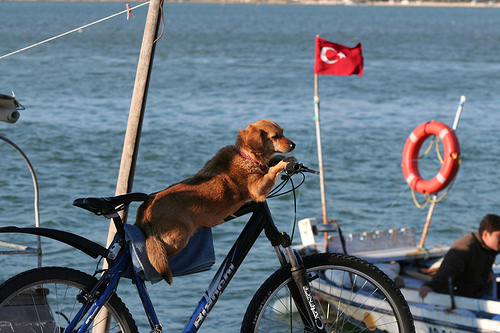

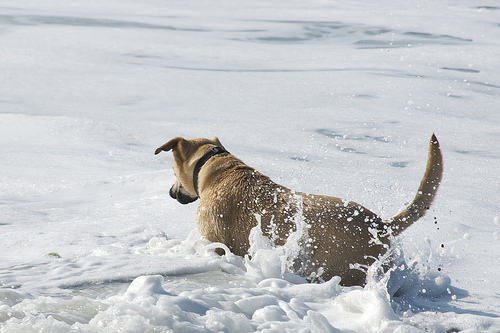

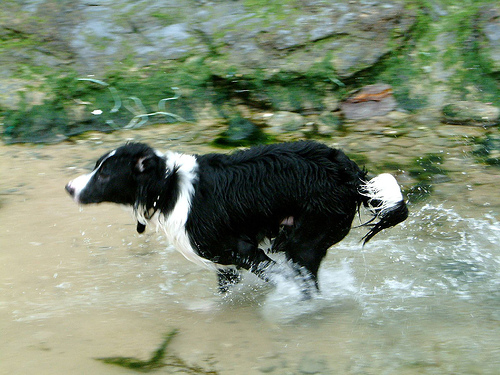

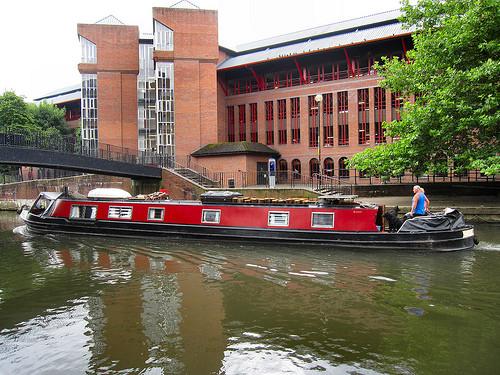

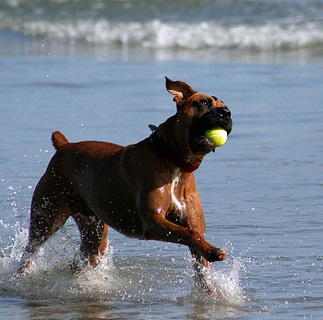

In [51]:
for im in ims:
    display(im)

In [54]:
def get_concept_scores(tensors, label):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    
    multiplier = 100000
    
    for key in tqdm.tqdm(concept_dict):
        diffss = []
        for tensor in tensors:
            embedding = model_bottom(tensor)
            original_preds = model_top(embedding).detach().numpy().squeeze()
            
            coef, _, _ = concept_dict[key]
            plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
            plus_preds = model_top(plus)
            plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
            diffss.append(plus_diff.detach().numpy())
        concept_scores[key] = np.mean(diffss)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [55]:
preds, scores2, lst = get_concept_scores(tensors, 'dog')
concepts2 = list(scores2.keys())
values2 = np.array(list(scores2.values()))
values2 = values2/np.max(np.abs(values2))

100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:44<00:00,  3.78it/s]


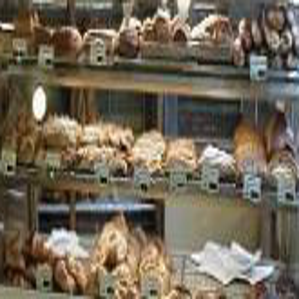

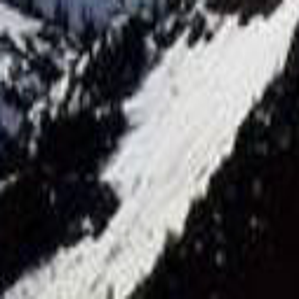

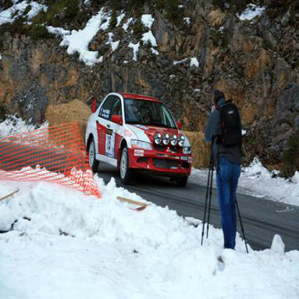

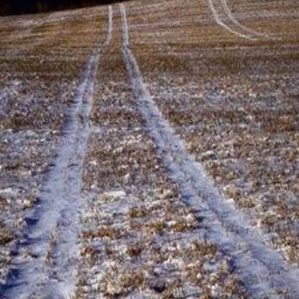

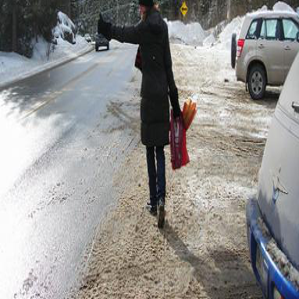

In [72]:
for i in range(5):
    c = 'snow'
    conc_dir = os.path.join('concept_data', c, 'positives')
    img_c = random.sample(os.listdir(conc_dir), 1)[0]
    im_c = PIL.Image.open(os.path.join(conc_dir, img_c))
    display(im_c)

In [85]:
diffs5 = []

for c in tqdm.tqdm(concepts):
    for i in range(3):
        x = data_transforms(ims[i])
        y_pred = model_ft(x.unsqueeze(0))
        y_pred = float(nn.Softmax(dim=-1)(y_pred)[0, 3])

        # take a random image of concept (snow)
        conc_dir = os.path.join('concept_data', c, 'positives')
        new_preds = []
        
        img_c = random.sample(os.listdir(conc_dir), 1)[0]
        im_c = PIL.Image.open(os.path.join(conc_dir, img_c))

        new_im = PIL.Image.new('RGB', (224*2, 224))
        new_im.paste(ims[i].resize((224,224)), (0,0))
        new_im.paste(im_c.resize((224,224)), (224,0))

        x = data_transforms(new_im)
        y_pred_ = model_ft(x.unsqueeze(0))
        y_pred_ = nn.Softmax(dim=-1)(y_pred_) 
        new_preds.append(float(y_pred_[0, 3]))

    diffs5.append(np.mean(new_preds) - y_pred)  

100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [01:20<00:00,  2.12it/s]


In [88]:
from scipy.stats import pearsonr
pearsonr(values2, diffs2)

(0.308466444146178, 4.267714980452706e-05)

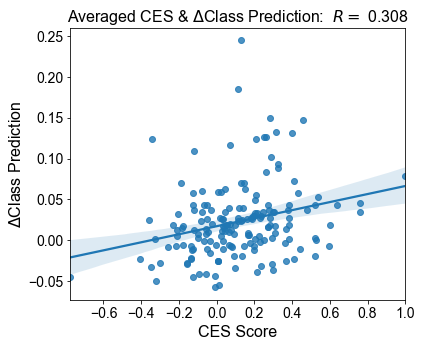

In [90]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=values, y=diffs)
plt.title('Averaged CES & $\Delta$Class Prediction:  $R=$ ' + str(round(pearsonr(values2, diffs2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('CES Score', fontname='Arial', fontsize=16)
plt.ylabel('$\Delta$Class Prediction', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

0.2297751009464264


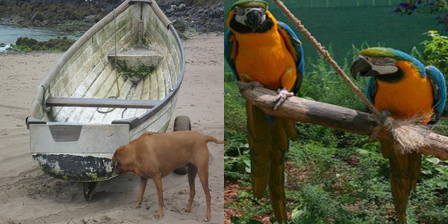

 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  5.50it/s]

0.2297751009464264


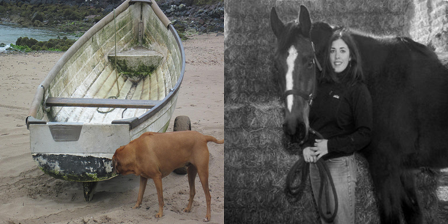

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:00<00:00,  5.84it/s]

0.2297751009464264


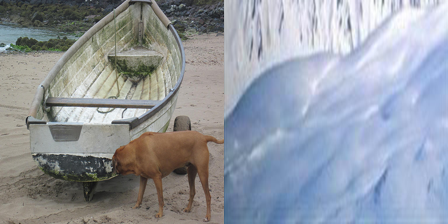

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.18it/s]


In [171]:
diffs = []
diffs_std = []

for c in tqdm.tqdm(['bird', 'bed', 'snow']):
    x = data_transforms(im)
    y_pred = model_ft(x.unsqueeze(0))
    y_pred = float(nn.Softmax(dim=-1)(y_pred)[0, 3])
    print(y_pred)
    
    # take a random image of concept (snow)
    conc_dir = os.path.join('concept_data', c, 'positives')
    new_preds = []
    
    img_c = random.sample(os.listdir(conc_dir), 1)[0]
    im_c = PIL.Image.open(os.path.join(conc_dir, img_c))

    new_im = PIL.Image.new('RGB', (224*2, 224))
    new_im.paste(im.resize((224,224)), (0,0))
    new_im.paste(im_c.resize((224,224)), (224,0))
    
    display(new_im)

    x = data_transforms(new_im)
    y_pred_ = model_ft(x.unsqueeze(0))
    y_pred_ = nn.Softmax(dim=-1)(y_pred_) 
    new_preds.append(float(y_pred_[0, 3]))

    diffs.append(np.mean(new_preds) - y_pred)  
    diffs_std.append(np.std(new_preds))

In [112]:
from sklearn.metrics import r2_score
print(r2_score(values, diffs))

-1.0721777893547983


In [159]:
olds = []
news = []

for i, img in enumerate(os.listdir(os.path.join(output_path, 'drift', 'dog'))):
    im = PIL.Image.open(os.path.join(output_path, 'drift', 'dog', img))
    x = data_transforms(im)
    y_pred = model_ft(x.unsqueeze(0))
    y_pred = nn.Softmax(dim=-1)(y_pred) 
    olds.append(float(y_pred[0, 3]))
    
    # take a random image of concept (snow)
    conc_dir = os.path.join('concept_data', 'snow', 'positives')
    im_c = PIL.Image.open(os.path.join(conc_dir, '2008_007759.png'))
    
    new_im = PIL.Image.new('RGB', (224*2, 224))
    new_im.paste(im.resize((224,224)), (0,0))
    new_im.paste(im_c.resize((224,224)), (224,0))
    
    x = data_transforms(new_im)
    y_pred_ = model_ft(x.unsqueeze(0))
    y_pred_ = nn.Softmax(dim=-1)(y_pred_) 
    news.append(float(y_pred_[0, 3]))    

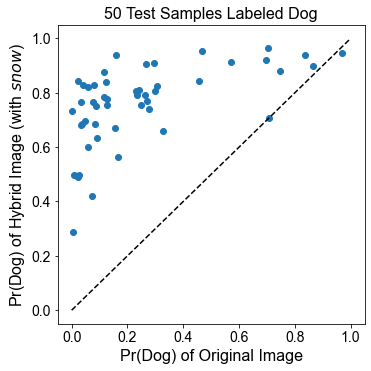

In [169]:
plt.figure(figsize=[5.5, 5.5])
plt.plot(olds, news, 'o')
plt.plot([0, 1], [0, 1], 'k--')

plt.title('50 Test Samples Labeled Dog', fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Pr(Dog) of Original Image', fontname='Arial', fontsize=16)
plt.ylabel('Pr(Dog) of Hybrid Image (with $snow$)', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [56]:
np.mean(diffs)

-0.04810991851612925

In [9]:
def get_concept_scores(tensor, label):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [10]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\zebra-fig1a.jpg").convert("RGB")
tensor = data_transforms(img).unsqueeze(0)

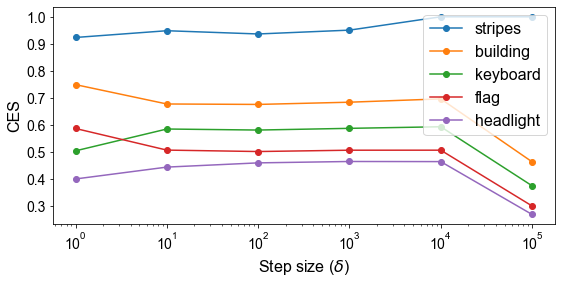

In [425]:
plt.figure(figsize=[9, 4])
for c in top_concepts:
    plt.semilogx(deltas, [all_scores[i][c] for i in range(len(all_scores))], '-o', label=c)
    
plt.legend(prop={'family':'Arial', 'size':16})
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Step size ($\delta$)', fontname='Arial', fontsize=16)
plt.ylabel('CES', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);